In [1]:
import numpy as np
import os
from lib.utils import process_sensor_data
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = 'sc_sensor'
# adding to the df_dict
# Loop through each subdirectory in the parent directory
df_dict = process_sensor_data(parent_dir, df_dict)  # only process sensor 2

In [2]:
from lib.utils import gen_data_dict, seperate_up_down
data_dict = gen_data_dict(df_dict)
# process data dict to get the upstream and downstream data
from lib.utils import seperate_up_down, generating_ood_dataset
data_dict = seperate_up_down(data_dict)

In [3]:
from torch.utils.data import DataLoader
from lib.dataloader import FlowDataset
from lib.utils import gen_data_dict, process_sensor_data, StandardScaler, sliding_win
from lib.utils import generating_ood_dataset, seperate_up_down, generating_insample_dataset, get_trainable_params_size
import dgl
import torch
import pickle
# set seed
torch.manual_seed(1)
#normalization
# x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
#                           std=np.concatenate([x_train, x_val]).std())

# dataset_name = "crossroad"
dataset_name = "train_station"
    
if dataset_name == "crossroad":
    file_path = 'graphs/graph_data_crossroad.pkl'
    with open(file_path, 'rb') as file:
        g = pickle.load(file)

elif dataset_name == "train_station":
    file_path = 'graphs/graph_data_trainstation.pkl'
    with open(file_path, 'rb') as file:
        g = pickle.load(file)


In [4]:
# data = data_dict['sc_sensor/crossroad1']
# x_train, y_train = sliding_win(data, lags=5, horizons=2)

In [5]:
if dataset_name == "crossroad":
    train_sc = ['sc_sensor/crossroad2']
    test_sc = ['sc_sensor/crossroad2_2']

if dataset_name == "train_station":
    train_sc = ['sc_sensor/train6']
    test_sc = ['sc_sensor/train1']

pred_horizon = 5
x_train, y_train, x_val, y_val, x_test, y_test = generating_ood_dataset(data_dict, train_sc, test_sc, lags=5, horizons=pred_horizon, shuffle=True)
# x_train, y_train, x_val, y_val, x_test, y_test = generating_insample_dataset(data_dict, train_sc,
#                                                                              lags=5,
#                                                                              horizons=pred_horizon,
#                                                                              portion=0.6,
#                                                                              shuffle=True)
num_input_timesteps = x_train.shape[1] # number of input time steps
num_nodes = x_train.shape[2] # number of ancestor nodes, minus the down stream node
# x_scalar = StandardScaler(mean=np.concatenate([x_train, x_val]).mean(),
#                           std=np.concatenate([x_train, x_val]).std())


In [6]:
# from Diffusion_Network import Diffusion_Model
# from Diffusion_Network2 import Diffusion_Model
from Diffusion_Network3_asc import Diffusion_Model
# from Diffusion_Network_density import Diffusion_Model_Density
# from Diffusion_Network_UQ import Diffusion_Model_UQ
src, dst = g.edges()
# model = Diffusion_Model_UQ(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)

# model = Diffusion_Model_Density(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)
model = Diffusion_Model(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3.pth"))
if dataset_name == "crossroad":
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3_cross.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/online_diffusion.pt"))
    model.load_state_dict(torch.load("./checkpoint/diffusion/offline_diffusion_uq_cross.pth"))
if dataset_name == "train_station":
    model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/online_diffusion_density.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_density.pth"))
    # model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_uq.pth"))

FileNotFoundError: [Errno 2] No such file or directory: './checkpoint/diffusion/diffusion_model_network3.pth'

In [7]:
# x = torch.cat(x_train, x_val, )
with torch.no_grad():
    x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    v = model.velocity_model(x_up, x_down).numpy()
    flow = torch.sum(x_up, dim=2).numpy()
    total_flow = torch.sum(torch.cat([x_up, x_down], dim=-1), dim=-1).numpy()

In [8]:
#netowrk2
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
pred = model.inference(g.ndata['feature'][src], g.ndata['feature'][dst])

In [9]:
#network
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))
z = model.transition_probability(g.ndata['feature'])
g.ndata['embedding'] = z   # for attention
g.apply_edges(model.transition_probability.edge_attention)

In [10]:
# generate matrix with the element is e
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    atten_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = g.edata['e'][i, :]
    # atten_mat = atten_mat.numpy()

In [11]:
# generate matrix with the element is e
np.around(atten_mat[..., -1].numpy(), 3)

array([[0.   , 0.   , 0.343, 0.   , 0.316, 0.   , 0.   , 0.341],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.41 , 0.   , 0.   , 0.285, 0.   , 0.   , 0.305],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.395, 0.309, 0.   , 0.   , 0.   , 0.   , 0.296],
       [0.   , 0.382, 0.316, 0.   , 0.302, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],
      dtype=float32)

In [13]:
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    alpha_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        alpha_mat[src[i], dst[i], :] = g.edata['alpha'][i, :]


<AxesSubplot:>

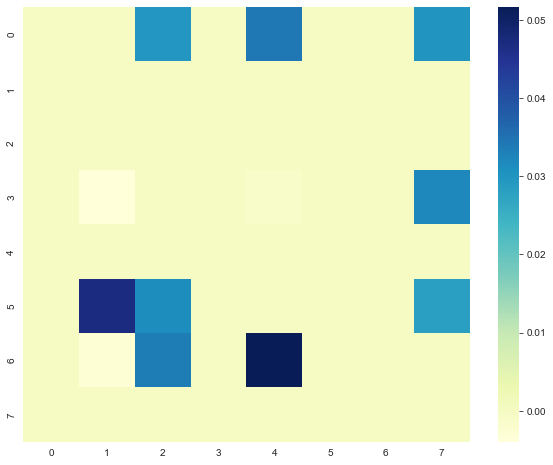

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(alpha_mat[..., -1], cmap="YlGnBu")

In [84]:
alpha_mat[22, 2, -1]

IndexError: index 22 is out of bounds for dimension 0 with size 8

<AxesSubplot:>

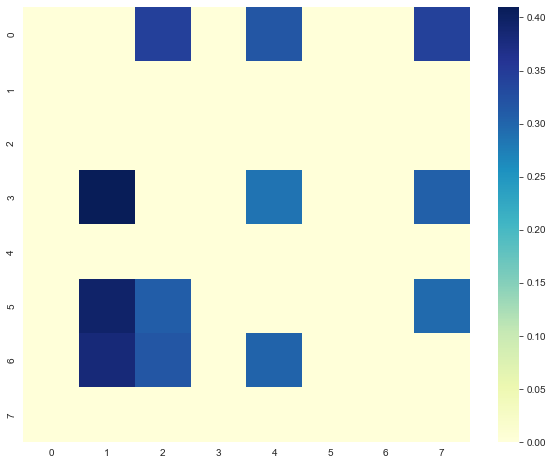

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(atten_mat[..., -1], cmap="YlGnBu")

In [46]:
import dgl
import torch

# Create a simple DGLGraph
# num_nodes = 5
# edges_src = [0, 1, 1, 2, 2, 3, 3, 4]
# edges_dst = [1, 2, 3, 3, 4, 4, 0, 1]
# graph = dgl.graph((edges_src, edges_dst), num_nodes=num_nodes)
# graph.edata['features'] = torch.randn(8, 10)
# src_idx, dst_idx = g.edges()
src_idx = np.unique(src)
# Get edge IDs going out from a specific source node
edge_ids_dict = dict()
for src_node_id in src_idx:
    outbound_edges = np.where(np.array(src) == src_node_id)[0]
    edge_ids_dict[src_node_id] = outbound_edges
    print(src_node_id)
    edge_data = g.edata['e'][outbound_edges, :]
    print(torch.sum(edge_data))
    # assert torch.sum(edge_data) != 354
    print("Edge Data:", edge_data.shape)
    print("outbound_edges:", outbound_edges)

# Extract edge features and destination nodes connected to the specified source node
# edge_data = graph.edata['features'][outbound_edges]
# src_nodes = graph.edges()[0][outbound_edges]
# dst_nodes = graph.edges()[1][outbound_edges]

# print("Edge Data:", edge_data)
# print("Source Nodes:", src_nodes)
# print("Destination Nodes:", dst_nodes)


0
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([3, 352])
outbound_edges: [46 47 48]
3
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([3, 352])
outbound_edges: [0 1 2]
4
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([3, 352])
outbound_edges: [3 4 5]
7
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([3, 352])
outbound_edges: [6 7 8]
8
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([5, 352])
outbound_edges: [17 18 19 20 21]
11
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([5, 352])
outbound_edges: [22 23 24 25 26]
12
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([5, 352])
outbound_edges: [49 50 51 52 53]
13
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([3, 352])
outbound_edges: [40 41 42]
14
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([5, 352])
outbound_edges: [27 28 29 30 31]
17
tensor(352., grad_fn=<SumBackward0>)
Edge Data: torch.Size([5, 352])
outbound_edges: [35 36 37 3

In [96]:
from scipy.stats import entropy
import torch.nn.functional as F
from torch import nn
# calculate the js divergence for each row
p = atten_mat[:, :, 50:53].numpy()
q = atten_mat[:, :, 51:54].numpy()
# p = p / np.sum(p, axis=1, keepdims=True)
# q = q / np.sum(q, axis=1, keepdims=True)

# Calculate the average distribution
m = 0.5 * (p + q)

# Calculate the Jensen-Shannon Divergence
jsd = 0.5 * (entropy(p, m) + entropy(q, m))
entropy(p, q)

/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/Users/mmai/anaconda3/envs/mps/lib/python3.9/site-packages/scipy/stats/_entropy.py:83: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


array([[          nan,           nan,           nan],
       [2.1099579e-05, 2.3797969e-05, 1.4653779e-07],
       [1.5126262e-04, 3.0482071e-05, 2.4064910e-05],
       [          nan,           nan,           nan],
       [2.6243972e-05, 1.2860633e-05, 5.7976576e-06],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [3.1818636e-05, 2.8539856e-05, 8.7149674e-06]], dtype=float32)

In [97]:
p = atten_mat
q = atten_mat
m = 0.5 * (p + q)
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

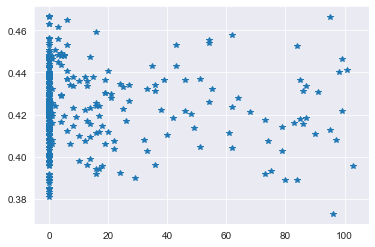

In [9]:
import matplotlib.pyplot as plt
edge_id = 3
plt.plot(flow[edge_id, :], v[:, edge_id], '*')


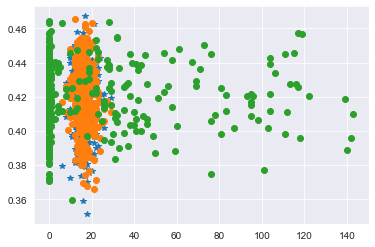

In [10]:
plt.plot(flow[0, :], v[:, 0], '*')
plt.plot(flow[1, :], v[:, 1], 'o')
plt.plot(flow[6, :], v[:, 6], 'o')

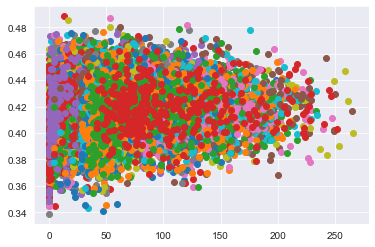

In [11]:
for i in range(total_flow.shape[0]):
    plt.plot(total_flow[i, :], v[:, i], 'o')

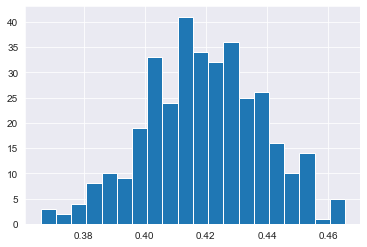

In [12]:
# distribution plot of the velocity
plt.hist(v[:, 1], bins=20)
plt.show()

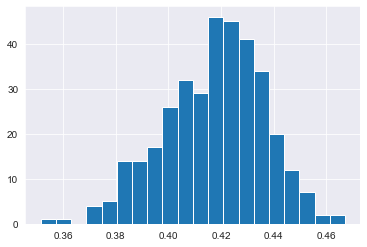

In [13]:
plt.hist(v[:, 0], bins=20)
plt.show()

In [14]:
model.alpha.clamp(min=0,max=1)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<ClampBackward1>)

In [16]:
# Extract x_up and x_down from the output
with torch.no_grad():
    v_model = model.velocity_model
    up = v_model.linear12(v_model.relu(v_model.ln11(v_model.dropout(v_model.linear11(x_up)))))
    up = torch.sigmoid(up)
    
    down = v_model.linear22(v_model.relu(v_model.ln21(v_model.dropout(v_model.linear21(x_down)))))
    down = torch.sigmoid(down)

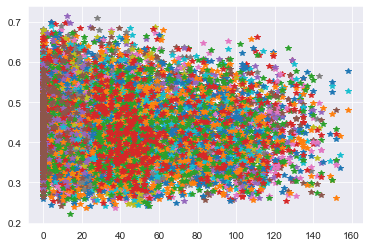

In [17]:
total_up_flow = torch.sum(x_up, dim=2).numpy()
up_flow_v = torch.sum(up, dim=2).numpy()
total_down_flow = torch.sum(x_down, dim=2).numpy()
down_flow_v = torch.sum(down, dim=2).numpy()
for i in range(total_up_flow.shape[0]):
    plt.plot(total_up_flow[i, :], up_flow_v[i, :], '*')

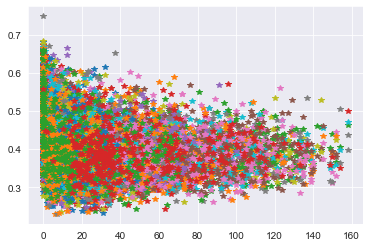

In [18]:
for i in range(total_up_flow.shape[0]):
    plt.plot(total_down_flow[i, :], down_flow_v[i, :], '*')


In [19]:
linear3_params = list(v_model.linear3.parameters())
# Print the parameters or do something with them
for param in linear3_params:
    print(param)

Parameter containing:
tensor([[ 0.4066, -0.6949]], requires_grad=True)
Parameter containing:
tensor([-0.5550], requires_grad=True)


## Visualization

In [7]:
from lib.metric import masked_rmse_np, masked_mae_np, rho_risk, weighted_average_loss
# data = data_dict['sc_sensor/crossroad2_2']
data = data_dict['sc_sensor/train2']
x_test, y_test = sliding_win(data, lags=5, horizons=pred_horizon)
# x_test2, y_test2 = sliding_win(data2, lags=5, horizons=2)
g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))

Text(0.5, 1.0, 'RMSE: 3.2421088218688965')

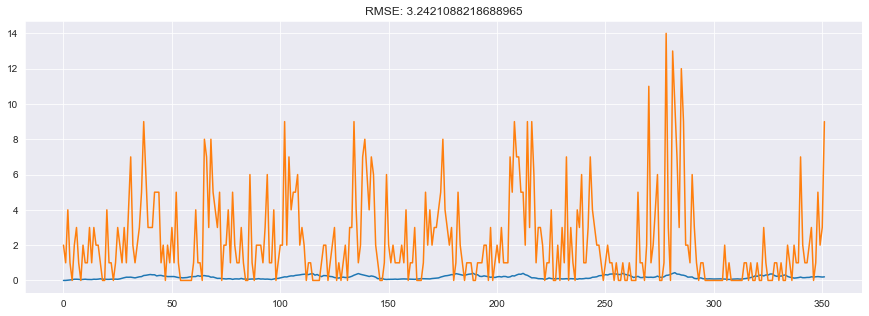

In [8]:
import matplotlib.pyplot as plt
id = 15
step = 3
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3.pth"))
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_model_network3_cross.pth"))
# model.load_state_dict(torch.load("./checkpoint/diffusion/diffusion_uq.pth"))
up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    pred, multi_step_pred = model.inference(up, down)
    pred, multi_step_pred = pred.numpy(), multi_step_pred.numpy()
    v = model.velocity_model(g.ndata['feature'][5].unsqueeze(0), g.ndata['feature'][id].unsqueeze(0)).numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])
# plt.plot(x, label2[id, :])
# plt.plot(x, label[3, :])
# plt.plot(x, label[0, :])
# plt.plot(x, label[14, :, step])
# plt.plot(x, v)
rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

Text(0.5, 1.0, 'RMSE: 3.0807769298553467')

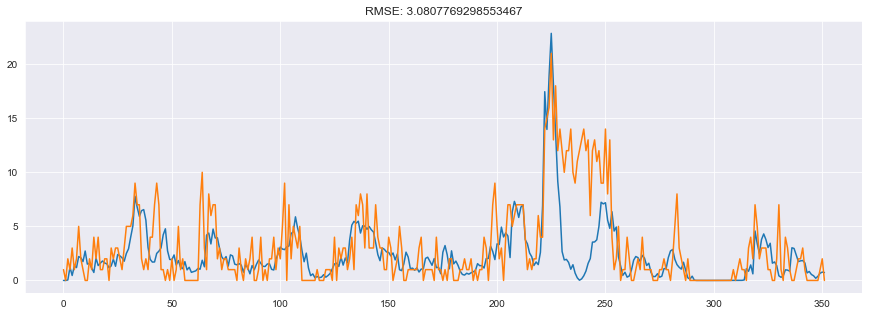

In [24]:
import matplotlib.pyplot as plt
# id = 1
# step = 3

up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    pred, multi_step_pred = model.inference(up, down)
    pred, multi_step_pred = pred.numpy(), multi_step_pred.numpy()
    v = model.velocity_model(g.ndata['feature'][5].unsqueeze(0), g.ndata['feature'][id].unsqueeze(0)).numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])

rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

KeyError: 'sigma'

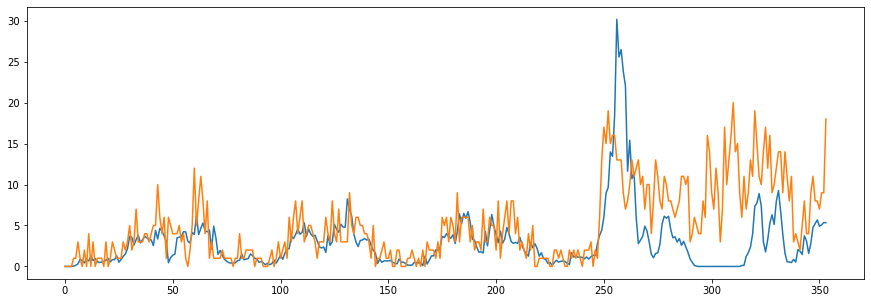

In [13]:
up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    pred, multi_step_pred = model.inference(up, down)
    pred, multi_step_pred = pred.numpy(), multi_step_pred.numpy()
    v = model.velocity_model(g.ndata['feature'][5].unsqueeze(0), g.ndata['feature'][id].unsqueeze(0)).numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
# plt.plot(x, pred[id, :, 0])
# plt.plot(x, label[id, :, 0])
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])
sigma = g.ndata['sigma'].numpy()
sigma = np.sqrt(pred + pred ** 2 * sigma)
# plot prediction interval
plt.fill_between(x, pred[id, :] - 2 * sigma[id, :], pred[id, :] + 2 * sigma[id, :], alpha=0.5)
# plt.plot(x, v)
rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

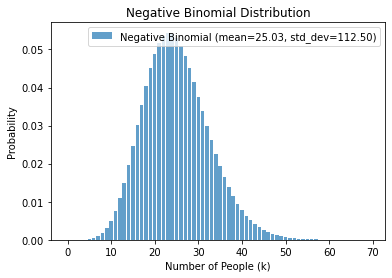

In [28]:
from scipy.stats import nbinom
ts = 227
# id = 2
# Set mean and standard deviation
mean = pred[id, ts]
std_dev = np.sqrt(pred[id, ts] + pred[id, ts]**2 * sigma[id, ts])

# Calculate shape parameter (k)
# k = (mean ** 2) / (std_dev ** 2)

# Generate x values for the plot
# x_values = np.arange(0, 2 * mean)
x_values = np.arange(0, 70)
# Calculate the probability mass function (PMF) for each x value
pmf_values = nbinom.pmf(x_values, n=sigma[id, ts], p=sigma[id, ts]/(sigma[id, ts] + mean))
# Plot the negative binomial distribution
plt.bar(x_values, pmf_values, label=f'Negative Binomial (mean={mean:.2f}, std_dev={std_dev:.2f})', alpha=0.7)
plt.title('Negative Binomial Distribution')
plt.xlabel('Number of People (k)')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [25]:
# g.ndata['feature'] = torch.FloatTensor(x_test.transpose(2, 0, 1))
# g.ndata['label'] = torch.FloatTensor(y_test.transpose(2, 0, 1))
z = model.transition_probability(g.ndata['feature'])
g.ndata['embedding'] = z   # for attention
g.apply_edges(model.transition_probability.edge_attention)

In [26]:
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    atten_mat = torch.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = g.edata['e'][i, :]
    atten_mat = atten_mat.numpy()

In [26]:
# xgboost
import xgboost as xgb
loaded_model = xgb.Booster()
loaded_model.load_model('./checkpoint/xgboost/offline_xgboost_train_station.model')
# loaded_model.load_model('./checkpoint/xgboost/xgboost_cross.model')

Text(0.5, 1.0, 'RMSE: 3.5434505939483643')

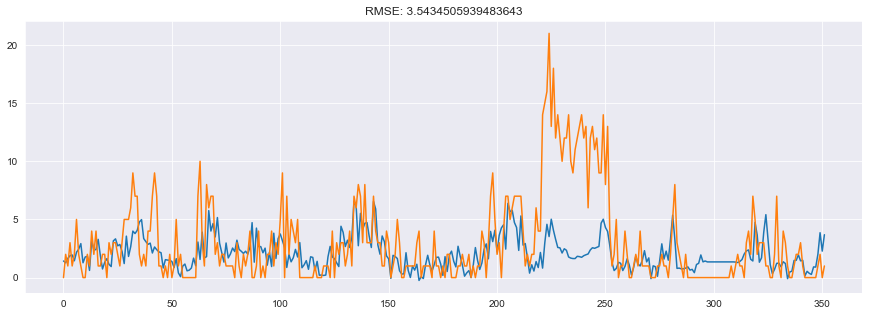

In [27]:
horizon = pred_horizon - 1
x = x_test.reshape([-1, num_input_timesteps * num_nodes])
# y = y_test.reshape([-1, pred_horizon * num_nodes])
# y_test = y_test.reshape([-1, num_input_timesteps * num_nodes])
pred = loaded_model.predict(xgb.DMatrix(x))
# pred = pred.reshape([num_nodes, -1, horizon])

pred = pred.reshape([-1, horizon, num_nodes]).transpose([2, 0, 1])
# pred = pred.T
x2 = np.arange(0, label.shape[1])
plt.figure(figsize=(15, 5))
plt.plot(x2, pred[id, :, step])  # node ts horizon
plt.plot(x2, label[id, :, step])
# plt.plot(x2, label[0, :])
rmse = masked_rmse_np(pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
plt.title(f'RMSE: {rmse}')

Text(0.5, 1.0, 'RMSE: 2.446524143218994')

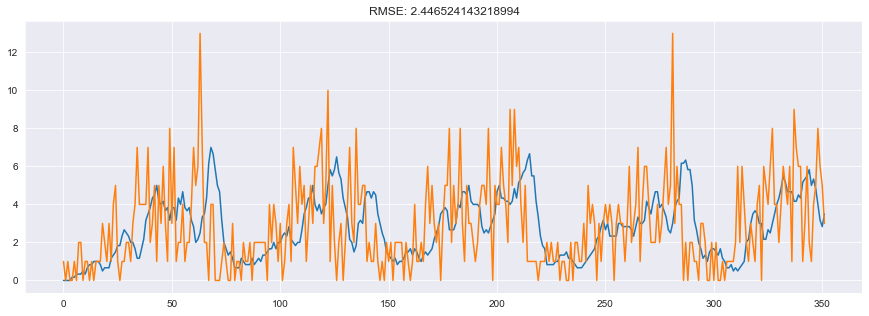

In [14]:
# MA
from baselines.MA import Moving_Average
ma = Moving_Average(horizons=pred_horizon)
pred = ma.inference(g.ndata['feature']).numpy()
label = y_test.transpose(2, 0, 1)
x2 = np.arange(0, label.shape[1])
id = 2
step = 3
x = np.arange(0, label.shape[1])

plt.figure(figsize=(15, 5))
plt.plot(x2, pred[id, :, step])  # node ts horizon
plt.plot(x2, label[id, :, step])
# plt.plot(x2, label[0, :])
rmse = masked_rmse_np(pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
plt.title(f'RMSE: {rmse}')

In [9]:
# gat
from baselines.GAT import GAT
adj_mat = g.adjacency_matrix(transpose=False, scipy_fmt="coo")
gat_model = GAT(g=adj_mat, seq_len=num_input_timesteps, feature_size=1, hidden_dim=32, out_dim=pred_horizon-1, nodes=num_nodes, num_heads=3)
gat_model.load_state_dict(torch.load("./checkpoint/gat/gat_trainstation.pth"))

<All keys matched successfully>

Text(0.5, 1.0, 'RMSE: 2.0614802837371826')

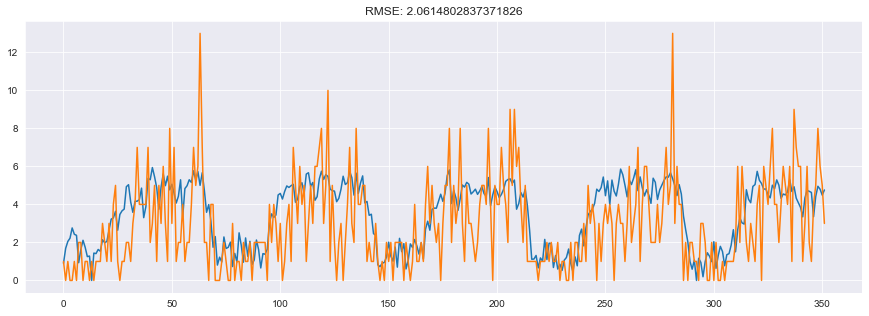

In [13]:
import matplotlib.pyplot as plt
id = 2
step = 3
# up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
# down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
with torch.no_grad():
    multi_step_pred = gat_model.inference(g.ndata['feature'].permute(1, 0, 2))
    multi_step_pred = multi_step_pred.numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])

rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

In [43]:
# gcn
from baselines.GCN import GCN
gcn_model = GCN(in_size=num_input_timesteps, hid_size=128, out_size=pred_horizon-1, scalar=None)  # out_size: prediction horizon
gcn_model.load_state_dict(torch.load("./checkpoint/gcn/gcn_trainstation.pth"))

<All keys matched successfully>

Text(0.5, 1.0, 'RMSE: 7.875597953796387')

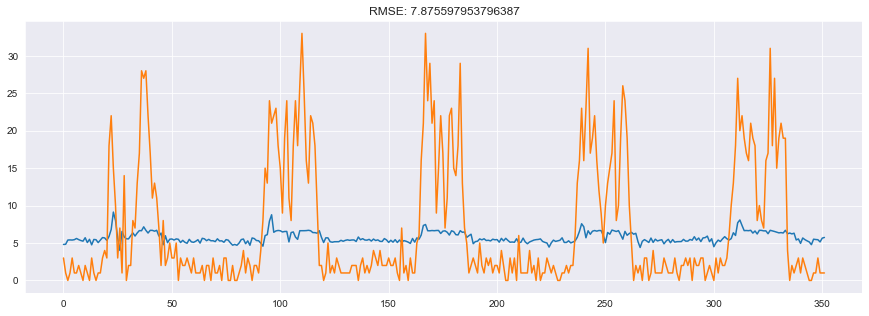

In [44]:
import matplotlib.pyplot as plt
id = 23
step = 3
# up = torch.FloatTensor(x_test.transpose(2, 0, 1))[src]
# down = torch.FloatTensor(x_test.transpose(2, 0, 1))[dst]
g = dgl.add_self_loop(g)
with torch.no_grad():
    multi_step_pred = gcn_model.inference(g, g.ndata['feature'])
    multi_step_pred = multi_step_pred.numpy()
# plot prediction and ground truth

# label = g.ndata['label'][:,:, 0].numpy()
label = y_test.transpose(2, 0, 1)
# label2 = y_test2.transpose(2, 0, 1)
x = np.arange(0, label.shape[1])

#adjust figure size
plt.figure(figsize=(15, 5))
plt.plot(x, multi_step_pred[id, :, step])
plt.plot(x, label[id, :, step])

rmse = masked_rmse_np(multi_step_pred[id, :, step], label[id, :, step])
# rt = np.sum(rho_risk(pred[id, :], label[id, :], timespan=2, rho=0.9))
# wt = weighted_average_loss(pred.T, label.T, rho=0.9, timespan=2)
plt.title(f'RMSE: {rmse}')

In [35]:
g

Graph(num_nodes=8, num_edges=44,
      ndata_schemes={'feature': Scheme(shape=(172, 6), dtype=torch.float32), 'embedding': Scheme(shape=(172, 64), dtype=torch.float32), 'multi_steps_pred': Scheme(shape=(172, 3), dtype=torch.float32), 'label': Scheme(shape=(172, 4), dtype=torch.float32)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'alpha': Scheme(shape=(1,), dtype=torch.float32), 'v': Scheme(shape=(172,), dtype=torch.float32), 'T': Scheme(shape=(172,), dtype=torch.float32), 'T_idx': Scheme(shape=(172,), dtype=torch.float32), 'diffusion': Scheme(shape=(172, 6), dtype=torch.float32), 'F': Scheme(shape=(172,), dtype=torch.float32), 'e': Scheme(shape=(172,), dtype=torch.float32), 'message': Scheme(shape=(172,), dtype=torch.float32)})

In [29]:
import dgl
import torch
import torch.nn.functional as F

# Example graph creation
src = np.array([0, 0, 0, 3, 3, 3, 5, 5, 5, 6, 6, 6])
dst = np.array([4, 2, 7, 1, 4, 7, 2, 7, 1, 2, 4, 1])
g = dgl.graph((src, dst))

# Example edge data
g.edata['e'] = torch.randn(g.number_of_edges())
g.edata['buffer'] = -1 * torch.ones([g.number_of_edges(), 4])
# traverse the dst node


In [15]:
T = torch.tensor([[0.1, 0.2, 0.3, 0.4, 0.5], [0.1, 0.2, 0.3, 0.4, 0.5]])
alpha = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5])
F = 1/(1 + alpha * T)
# f = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5])
n = torch.tensor([[1, 2, 3, 4, 5],[1, 2, 3, 4, 5]])
for i in zip(n, F):
    print(i)

(tensor([1, 2, 3, 4, 5]), tensor([0.9901, 0.9615, 0.9174, 0.8621, 0.8000]))
(tensor([1, 2, 3, 4, 5]), tensor([0.9901, 0.9615, 0.9174, 0.8621, 0.8000]))


In [16]:
src = np.array([0, 0, 0, 3, 3, 3, 5, 5, 5, 6, 6, 6])
dst = np.array([4, 2, 7, 1, 4, 7, 2, 7, 1, 2, 4, 1])
g = dgl.graph((src, dst))
g.edata['distance'] = torch.FloatTensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]) # 50m
# save the graph
with open('graphs/graph_data.pkl', 'wb') as file:
    pickle.dump(g, file)

torch.Size([2, 5])

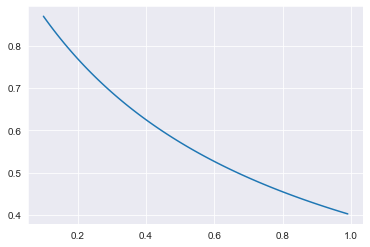

In [64]:
# 
v = 1.5
alpha = np.arange(0.1, 1, 0.01)
F = 1/(1+alpha*v)
plt.plot(alpha, F)

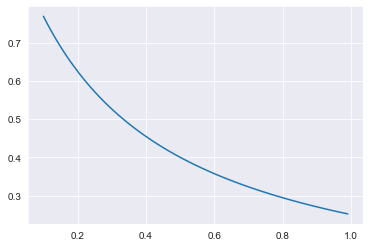

In [65]:
v = 3
alpha = np.arange(0.1, 1, 0.01)
F = 1/(1+alpha*v)
plt.plot(alpha, F)